# Estimation on real data using MSM

In [1]:
from consav import runtools
runtools.write_numba_config(disable=0,threads=4)

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Local modules
from Model import RetirementClass
import figs
import SimulatedMinimumDistance as SMD

# Global modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Data

In [17]:
data = pd.read_excel('SASdata/moments.xlsx')
mom_data = data['mom'].to_numpy()
se = data['se'].to_numpy()
obs = data['obs'].to_numpy()
se = se/np.sqrt(obs)
se[se>0] = 1/se[se>0]
factor = np.ones(len(se))
factor[-15:] = 4
W = np.eye(len(se))*se*factor
cov = pd.read_excel('SASdata/Cov.xlsx')
Omega = cov*obs
Nobs = np.median(obs)

### Set up estimation

In [2]:
single_kwargs = {'simN': int(1e5), 'simT': 68-53+1}
Couple = RetirementClass(couple=True, single_kwargs=single_kwargs, 
                         simN=int(1e5), simT=68-53+1)
Couple.solve()
Couple.simulate()

In [59]:
def mom_fun(Couple):
    return SMD.MomFun(Couple)

In [60]:
est_par = ["alpha_0_male", "alpha_0_female", "sigma_eta", "pareto_w", "phi_0_male"]
smd = SMD.SimulatedMinimumDistance(Couple,mom_data,mom_fun,est_par=est_par)

### Estimate

In [61]:
theta0 = SMD.start(9,bounds=[(0,1), (0,1), (0.2,0.8), (0.2,0.8), (0,2)])

In [62]:
theta0

[[0.878, 0.939, 0.494, 0.501, 1.482],
 [0.977, 0.97, 0.23, 0.493, 0.119],
 [0.075, 0.755, 0.446, 0.641, 1.784],
 [0.422, 0.416, 0.587, 0.292, 0.241],
 [0.932, 0.964, 0.682, 0.351, 1.553],
 [0.885, 0.083, 0.46, 0.651, 1.52],
 [0.404, 0.689, 0.531, 0.61, 1.184],
 [0.019, 0.665, 0.645, 0.521, 1.796],
 [0.555, 0.039, 0.415, 0.692, 0.001]]

In [63]:
smd.MultiStart(theta0,W)
theta = smd.est

1 estimation:
success: True | feval: 294 | time: 68.7 min | obj: 16.905881405720866
start par: [0.878, 0.939, 0.494, 0.501, 1.482]
par:       [0.5510516  0.52007452 0.69700755 0.83112885 0.21190369]

2 estimation:
success: True | feval: 349 | time: 80.5 min | obj: 18.743042219364817
start par: [0.977, 0.97, 0.23, 0.493, 0.119]
par:       [ 0.56730198  0.49988837  0.61304702  0.7803967  -0.04185609]

3 estimation:
success: True | feval: 294 | time: 70.3 min | obj: 32.16736516479271
start par: [0.075, 0.755, 0.446, 0.641, 1.784]
par:       [0.32828476 0.66112227 0.95527434 1.46132755 3.54434154]

4 estimation:
success: True | feval: 237 | time: 57.1 min | obj: 16.929741033852547
start par: [0.422, 0.416, 0.587, 0.292, 0.241]
par:       [0.55256372 0.52567413 0.69690618 0.81814051 0.18685789]

5 estimation:
success: True | feval: 374 | time: 89.6 min | obj: 25.487253110929686
start par: [0.932, 0.964, 0.682, 0.351, 1.553]
par:       [0.62460141 0.70705836 1.2125916  0.82666782 0.30013556]

In [9]:
smd.MultiStart(theta0,W)
theta = smd.est

Iteration: 50 (11.08 minutes)
 alpha_0_male=0.5044 alpha_0_female=0.4625 sigma_eta=0.8192 pareto_w=0.7542 phi_0_male=0.1227 -> 21.6723
Iteration: 100 (11.19 minutes)
 alpha_0_male=0.5703 alpha_0_female=0.5002 sigma_eta=0.7629 pareto_w=0.7459 phi_0_male=0.1575 -> 17.7938
Iteration: 150 (10.73 minutes)
 alpha_0_male=0.5546 alpha_0_female=0.5131 sigma_eta=0.6877 pareto_w=0.8166 phi_0_male=0.1905 -> 16.9717
Iteration: 200 (10.94 minutes)
 alpha_0_male=0.5526 alpha_0_female=0.5128 sigma_eta=0.6891 pareto_w=0.8133 phi_0_male=0.1875 -> 16.9319
1 estimation:
success: True | feval: 248 | time: 54.8 min | obj: 16.927585558076142
start par: [0.551, 0.576, 0.596, 0.5, 1.241]
par:       [0.55258074 0.51274232 0.68921531 0.81324937 0.18777072]

Iteration: 250 (11.3 minutes)
 alpha_0_male=0.6206 alpha_0_female=0.5880 sigma_eta=0.4200 pareto_w=0.4980 phi_0_male=0.5590 -> 57.7093
Iteration: 300 (11.24 minutes)
 alpha_0_male=0.5428 alpha_0_female=0.4145 sigma_eta=0.6379 pareto_w=0.5308 phi_0_male=0.3868

### Save parameters

In [64]:
est_par.append('phi_0_female')
thetaN = list(theta)
thetaN.append(Couple.par.phi_0_male)
SMD.save_est(est_par,thetaN,name='baseline2')

### Standard errors

In [123]:
est_par = ["alpha_0_male", "alpha_0_female", "sigma_eta", "pareto_w", "phi_0_male"]
smd = SMD.SimulatedMinimumDistance(Couple,mom_data,mom_fun,est_par=est_par)

In [124]:
theta = list(SMD.load_est('baseline2').values())
theta = theta[:5]
smd.obj_fun(theta,W)

16.933593151568864

In [125]:
np.round(theta,3)

array([0.551, 0.52 , 0.697, 0.831, 0.212])

In [67]:
Nobs = np.quantile(obs,0.25)
smd.std_error(theta,Omega,W,Nobs,Couple.par.simN*2/Nobs)

In [68]:
# Nobs = lower quartile
np.round(smd.std,3)

array([0.004, 0.014, 0.006, 0.013, 0.012])

In [58]:
# Nobs = lower quartile
np.round(smd.std,3)

array([0.009, 0.012, 0.009, 0.009, 0.011])

In [ ]:
Nobs = np.quantile(obs,0.25)
smd.std_error(theta,Omega,W,Nobs,Couple.par.simN*2/Nobs)

In [44]:
# Nobs = median
np.round(smd.std,3)

array([0.004, 0.005, 0.004, 0.004, 0.004])

### Model fit

In [9]:
smd.obj_fun(theta,W)

16.92237774565719

In [106]:
jmom = pd.read_excel('SASdata/joint_moments_ad.xlsx')

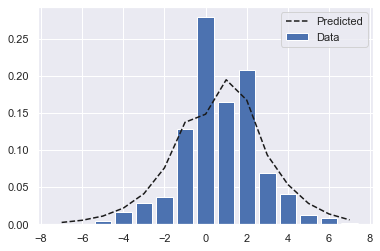

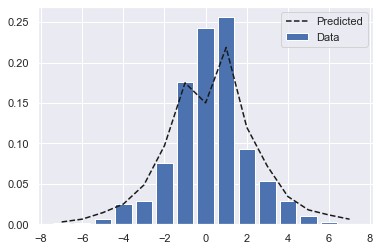

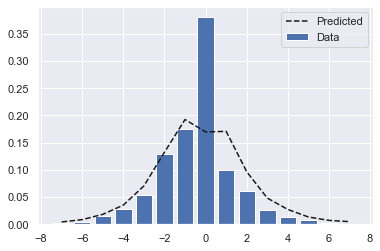

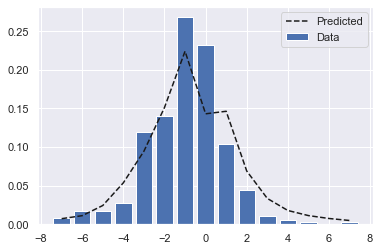

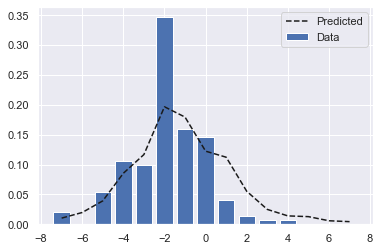

In [112]:
for i in range(-2,3):
    data = jmom[jmom.Age_diff==i]['ssh'].to_numpy()
    plt.bar(np.arange(-7,8), data, label='Data')
    plt.plot(np.arange(-7,8),SMD.joint_moments_ad(Couple,i),'k--', label='Predicted')
    #plt.ylim(0,0.4)
    plt.legend()
    plt.show()

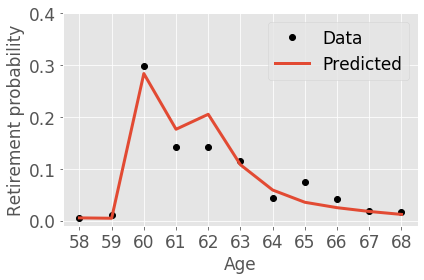

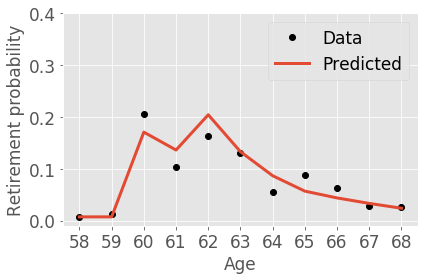

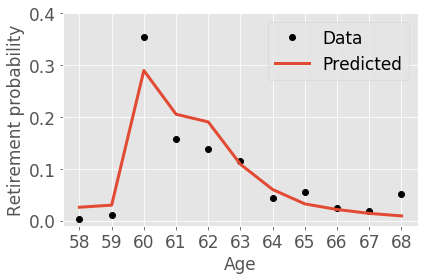

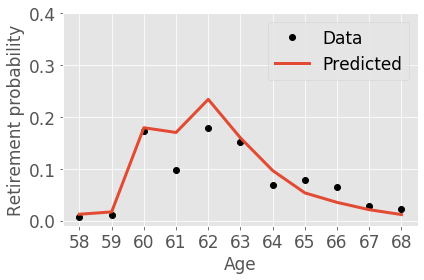

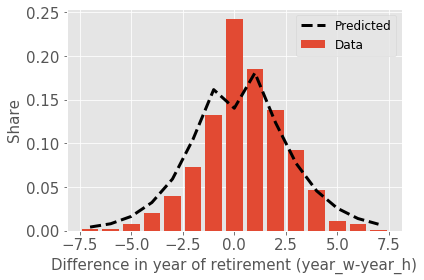

In [70]:
figs.MyPlot(figs.model_fit_marg(smd,0,0),ylim=[-0.01,0.4],linewidth=3).savefig('figs/ModelFit/MargWomenSingle2.png')
figs.MyPlot(figs.model_fit_marg(smd,1,0),ylim=[-0.01,0.4],linewidth=3).savefig('figs/ModelFit/MargMenSingle2.png')
figs.MyPlot(figs.model_fit_marg(smd,0,1),ylim=[-0.01,0.4],linewidth=3).savefig('figs/ModelFit/MargWomenCouple2.png')
figs.MyPlot(figs.model_fit_marg(smd,1,1),ylim=[-0.01,0.4],linewidth=3).savefig('figs/ModelFit/MargMenCouple2.png')
figs.model_fit_joint(smd).savefig('figs/ModelFit/Joint2')

In [114]:
theta[4] = 1
smd.obj_fun(theta,W)
dist1 = smd.mom_sim[44:]
theta[4] = 2
smd.obj_fun(theta,W)
dist2 = smd.mom_sim[44:]
theta[4] = 3
smd.obj_fun(theta,W)
dist3 = smd.mom_sim[44:]
dist_data = mom_data[44:]

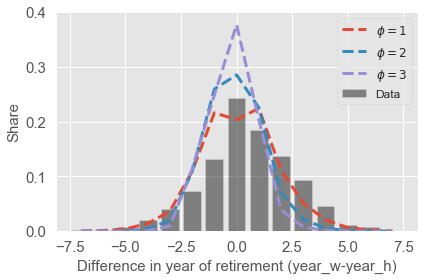

In [122]:
figs.model_fit_joint_many(dist_data,dist1,dist2,dist3).savefig('figs/ModelFit/JointMany2')

### Sensitivity

In [74]:
est_par_tex = [r'$\alpha^m$', r'$\alpha^f$', r'$\sigma$', r'$\lambda$', r'$\phi$']
fixed_par = ['R', 'rho', 'beta', 'gamma', 'v',
             'priv_pension_male', 'priv_pension_female', 'g_adjust', 'pi_adjust_m', 'pi_adjust_f']
fixed_par_tex = [r'$R$', r'$\rho$', r'$\beta$', r'$\gamma$', r'$v$',
                 r'$PPW^m$', r'$PPW^f$', r'$g$', r'$\pi^m$', r'$\pi^f$']

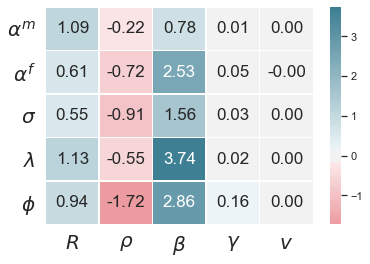

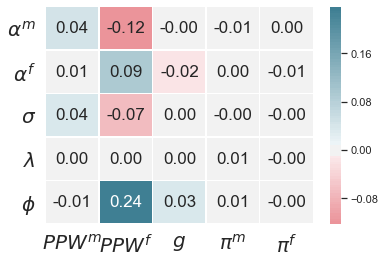

In [75]:
smd.recompute=True
smd.sensitivity(theta,W,fixed_par)
figs.sens_fig_tab(smd.sens2[:,:5],smd.sens2e[:,:5],theta,
                  est_par_tex,fixed_par_tex[:5]).savefig('figs/ModelFit/CouplePref2.png')
figs.sens_fig_tab(smd.sens2[:,5:],smd.sens2e[:,5:],theta,
                  est_par_tex,fixed_par_tex[5:]).savefig('figs/modelFit/CoupleCali2.png')

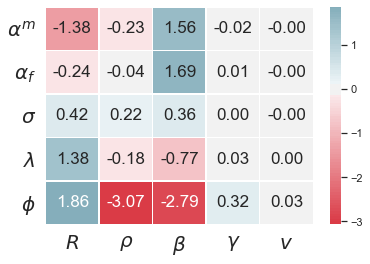

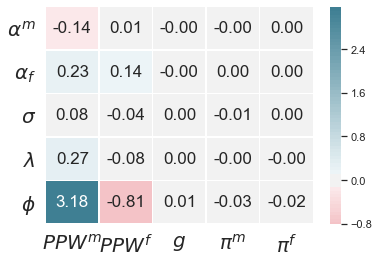

In [19]:
smd.recompute=True
smd.sensitivity(theta,W,fixed_par)
figs.sens_fig_tab(smd.sens2[:,:5],smd.sens2e[:,:5],theta,
                  est_par_tex,fixed_par_tex[:5]).savefig('figs/ModelFit/CouplePref.png')
figs.sens_fig_tab(smd.sens2[:,5:],smd.sens2e[:,5:],theta,
                  est_par_tex,fixed_par_tex[5:]).savefig('figs/modelFit/CoupleCali.png')

### Recalibrate model (phi=0)

In [6]:
Couple.par.phi_0_male = 0
Couple.par.phi_0_female = 0

In [7]:
est_par = ["alpha_0_male", "alpha_0_female", "sigma_eta", "pareto_w"]
smd = SMD.SimulatedMinimumDistance(Couple,mom_data,mom_fun,est_par=est_par)

In [8]:
theta0 = SMD.start(4,bounds=[(0,1), (0,1), (0.2,0.8), (0.2,0.8)])

In [9]:
smd.MultiStart(theta0,W)
theta = smd.est

1 estimation:
success: True | feval: 220 | time: 48.2 min | obj: 18.075899540131683
start par: [0.878, 0.939, 0.494, 0.501]
par:       [0.57538856 0.53292983 0.66919452 0.78768373]

2 estimation:
success: True | feval: 268 | time: 59.8 min | obj: 18.06436034188825
start par: [0.741, 0.977, 0.782, 0.23]
par:       [0.57877531 0.52225649 0.67987012 0.77814082]

3 estimation:
success: True | feval: 263 | time: 59.3 min | obj: 18.025100144784872
start par: [0.489, 0.059, 0.245, 0.653]
par:       [0.57954467 0.52886497 0.68641805 0.78896568]

4 estimation:
success: True | feval: 193 | time: 44.8 min | obj: 18.05028603223897
start par: [0.409, 0.736, 0.735, 0.453]
par:       [0.58045624 0.52222793 0.67634017 0.78087117]

final estimation:
success: True | feval: 146 | obj: 18.02470109022947
total estimation time: 4.1 hours
start par: [0.57954467 0.52886497 0.68641805 0.78896568]
par: [0.57954205 0.52886806 0.68643258 0.7889642 ]



In [10]:
est_par.append("phi_0_male")
est_par.append("phi_0_female")
theta = list(theta)
theta.append(Couple.par.phi_0_male)
theta.append(Couple.par.phi_0_male)
SMD.save_est(est_par,theta,name='phi0')

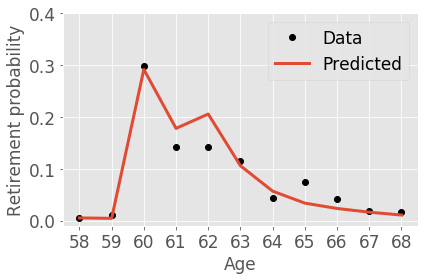

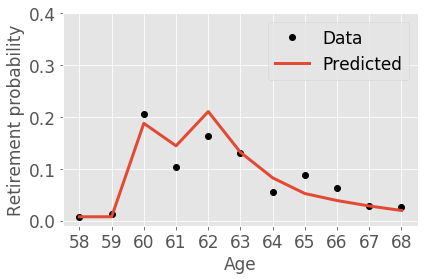

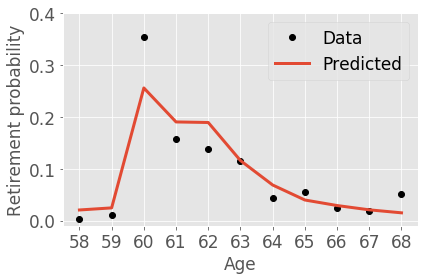

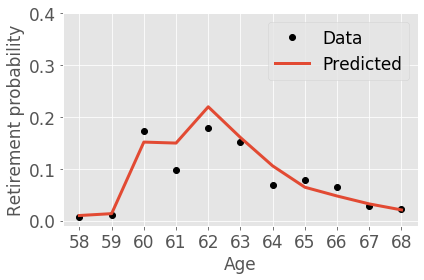

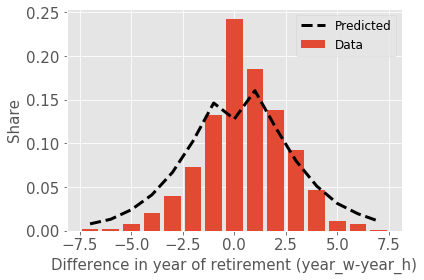

In [11]:
smd.obj_fun(theta,W)
figs.MyPlot(figs.model_fit_marg(smd,0,0),ylim=[-0.01,0.4],linewidth=3).savefig('figs/ModelFit/MargWomenSingle_phi0.png')
figs.MyPlot(figs.model_fit_marg(smd,1,0),ylim=[-0.01,0.4],linewidth=3).savefig('figs/ModelFit/MargMenSingle_phi0.png')
figs.MyPlot(figs.model_fit_marg(smd,0,1),ylim=[-0.01,0.4],linewidth=3).savefig('figs/ModelFit/MargWomenCouple_phi0.png')
figs.MyPlot(figs.model_fit_marg(smd,1,1),ylim=[-0.01,0.4],linewidth=3).savefig('figs/ModelFit/MargMenCoupleW_phi0.png')
figs.model_fit_joint(smd).savefig('figs/ModelFit/Joint_phi0')

### Recalibrate model (phi high)

In [6]:
Couple.par.phi_0_male = 1.187
Couple.par.phi_0_female = 1.671
Couple.par.pareto_w = 0.8

In [7]:
est_par = ["alpha_0_male", "alpha_0_female", "sigma_eta"]
smd = SMD.SimulatedMinimumDistance(Couple,mom_data,mom_fun,est_par=est_par)

In [8]:
theta0 = SMD.start(4,bounds=[(0.2,0.6), (0.2,0.6), (0.4,0.8)])

In [9]:
theta0

[[0.551, 0.576, 0.596],
 [0.4, 0.496, 0.791],
 [0.588, 0.22, 0.596],
 [0.224, 0.23, 0.702]]

In [10]:
smd.MultiStart(theta0,W)
theta = smd.est

1 estimation:
success: True | feval: 112 | time: 25.5 min | obj: 31.24196829478647
start par: [0.551, 0.576, 0.596]
par:       [0.39309581 0.44701373 0.78087338]



KeyboardInterrupt: 

In [ ]:
est_par.append("phi_0_male")
est_par.append("phi_0_female")
theta = list(theta)
theta.append(Couple.par.phi_0_male)
theta.append(Couple.par.phi_0_male)
SMD.save_est(est_par,theta,name='phi_high')

In [ ]:
smd.obj_fun(theta,W)
figs.MyPlot(figs.model_fit_marg(smd,0,0),ylim=[-0.01,0.4],linewidth=3).savefig('figs/ModelFit/MargWomenSingle_phi_high.png')
figs.MyPlot(figs.model_fit_marg(smd,1,0),ylim=[-0.01,0.4],linewidth=3).savefig('figs/ModelFit/MargMenSingle_phi_high.png')
figs.MyPlot(figs.model_fit_marg(smd,0,1),ylim=[-0.01,0.4],linewidth=3).savefig('figs/ModelFit/MargWomenCouple_phi_high.png')
figs.MyPlot(figs.model_fit_marg(smd,1,1),ylim=[-0.01,0.4],linewidth=3).savefig('figs/ModelFit/MargMenCoupleW_phi_high.png')
figs.model_fit_joint(smd).savefig('figs/ModelFit/Joint_phi_high')